In [1]:
%matplotlib inline
from pathlib import Path
from time import monotonic, sleep

import numpy as np
import matplotlib.pyplot as plt
import math

import qcodes as qc
from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.dataset.descriptions.detect_shapes import detect_shape_of_measurement
from qcodes.logger import start_all_logging
start_all_logging()

from scipy.optimize import curve_fit
import numpy as np

from ultolib import (anritsu, korad, spincore)
from ultolib.spincore import pulse
import qcodes.instrument_drivers.stanford_research as stanford_research

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nv-group01\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nv-group01\.qcodes\logs\240609-316-qcodes.log


In [2]:
# Note : this will generate two deprecation warnings when creating the pulse_blaster
pulse_blaster = spincore.PulseBlasterESRPRO(name='pulse_blaster', board_number=0)
pulse_blaster.core_clock(500)                     #Sets the clock speed, 
                                                  #must be called immediately after connecting to the PulseBlaster
lock_in_amp = stanford_research.SR830(name='lock_in_amp', address='ASRL5::INSTR', terminator='\r')

microwave_src=anritsu.MG3681A(name='microwave_src', address='ASRL4::INSTR', terminator='\r\n')
microwave_src.output('OFF')
microwave_src.output_level_unit('dBm')
microwave_src.IQ_modulation('EXT')

dc_supply = korad.KD3305P('dc_supply', 'ASRL6::INSTR')
dc_supply.ch1.voltage_setpoint(0)
dc_supply.ch1.current_setpoint(0)

pulse_blaster.stop()

Connected to: Stanford_Research_Systems SR830 (serial:s/n32132, firmware:ver1.07) in 0.33s
Connected to: ANRITSU MG3681A (serial:6100146424, firmware:3.03) in 0.15s
Connected to: KORAD KD3005P V6.7 SN 48562561 (serial:None, firmware:None) in 0.04s


0

## Task 2.3: The Hyperfine Splitting

The negatively charged vacancy in the NV center couples to the spin of its 14N nuclei which is a non-zero spin system. This will lead to further splitting of the electronic energy levels, known as hyperfine splitting.

For this task set the magnetic field to 0.005 T. 

Note: For this task, Task 2.2 must have been completed and the coil_constant determined.

In [3]:
coil_constant =  0.01 #Coil constant value determined in ODMR Magnetometry lab
B0 = 0.005
I0 = B0/coil_constant
dc_supply.ch1.voltage_setpoint(12)
dc_supply.ch1.current_setpoint(I0)

Perform an ODMR experiment to find the resonance peak at the highest frequency. Ensure that the coil current is not so high that the resonance of the peak exceeds 3 GHz. If that is the case, lower the B0 in the above code cell. You can consult your ODMR map to get an idea about the frequency range. For this ODMR peak, we will perform a high resolution ODMR scan centered around the chosen peak. Enter the values for the minimum and maximum frequencies to be scanned in the spectrum, below. Initially, it may help to scan a larger range in order to locqate the peak and then tighten the range to get a better scan.

Repeat this experiment for microwave powers 9 dbm, 6 dBm and -3 dB. You may have to increase the lock-in amplifier time constant at -3 dBm.
**The microwave frequency must be $\leq 3$ GHz.**

In [4]:
#Use this to make a parameter out of anything!
MW= qc.ManualParameter('Frequency', unit='Hz')
LI_R = qc.ManualParameter('Signal', unit='V')

#We start by stopping the laser pulsing. This way we can properly initialize.
initialise_or_create_database_at(Path.cwd() / "Hyperfine Splitting.db")
experiment = load_or_create_experiment(
    experiment_name='Hyperfine Splitting',
    sample_name=""
)

meas = Measurement(exp=experiment, name='Hyperfine Splitting')
meas.register_parameter(MW)  # register the first independent parameter
meas.register_parameter(LI_R) # now register the dependent one

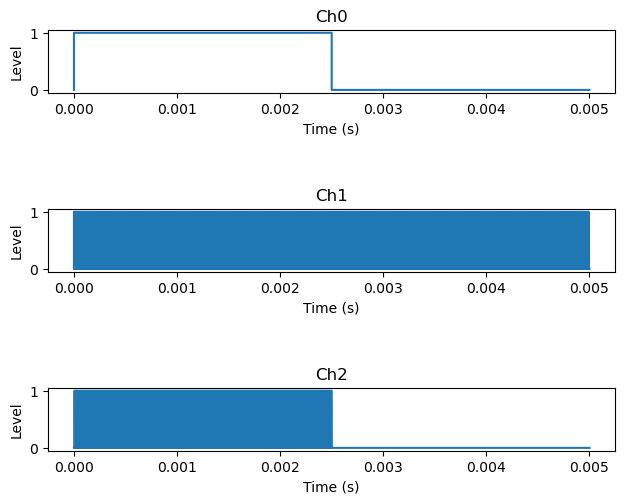

In [5]:
ref_f = 200                                 #Reference frequency.
ref_D =  0.5                                #Reference duty cycle.
T_ref_on =  ref_D/ref_f                             #Reference time on.
T_ref_off =  (1-ref_D) / ref_f                            #Reference time off.


laser_f =  100e3                              #Laser modulation frequency.
laser_D =  0.3                              #Laser modulation duty cycle.
T_laser_on =  laser_D/laser_f                           #Laser on time. 
T_laser_off =  (1-laser_D)/laser_f                          #Laser off time.
N_laser_pulses =  round(laser_f/ref_f)                       #Number of laser pulses that can fit in the reference period.

mw_f =  laser_f                                 #Microwave modulation frequency.
mw_D =  laser_D                                 #Microwave modulation duty cycle.
T_mw_on =  (1-laser_D)/laser_f                             #Microwave time on.
T_mw_off =  laser_D/laser_f                             #Microwave time off.
N_mw_pulses =  round(laser_f/(ref_f*2))                          #Number of microwave pulses that can fit in the reference period.

tau = 1e-6

# T_padding = 
# T_mw_off -= T_padding

def Hyperfine_Splitting_PP():
    pulse_blaster.reset_channel_buffer()  #Clear the previous pulse sequence.
    pulse_blaster.ch0.pulse_sequence_buffer.set(
        [pulse(level=1, duration=T_ref_on), pulse(level=0, duration=T_ref_off)]
    )                                     #Define the new pulse sequence for channel 0.
    pulse_blaster.ch1.pulse_sequence_buffer.set(
        [[pulse(level=1, duration=T_laser_on), pulse(level=0, duration=T_laser_off)] for i in range(0, N_laser_pulses)]   
    #TODO: Enter the laser pulse sequence.
        
    )                                     #Define the new pulse sequence for channel 1.
    pulse_blaster.ch2.pulse_sequence_buffer.set(
        [[pulse(level=0, duration=T_mw_off+tau), pulse(level=1, duration= T_mw_on-2*tau),  pulse(level=0, duration=tau)] for i in range(0, N_mw_pulses)] +
        [pulse(level=0, duration=float(1/(2*ref_f)))]
    )                                     #Define the new pulse sequence for channel 2.

Hyperfine_Splitting_PP()
pulse_blaster.plot_channel_buffer()

In [6]:
pulse_blaster.stop()
microwave_src.output('OFF')

lock_in_amp.time_constant(3)
lock_in_amp.sensitivity(100e-12)

#TODO: Enter the ODMR frequency range.
#NOTE: Must not be > 3 GHz (why not? Couldn't we interleave the channels part way through to look at a larger range?)
#TODO: Enter the ODMR frequency range.
min_frequency = 2.760e9#2.751616e+09#2.6e9                  #Minimum frequency for the spectrum
max_frequency = 2.772e9#2.777778e+09#3e9                  #Maximum frequency for the spectrum, #Must not be > 3 GHz.
# min_frequency = 2.6e9#2.751616e+09#2.6e9                  #Minimum frequency for the spectrum
# max_frequency = 3e9#2.777778e+09#3e9                  #Maximum frequency for the spectrum, #Must not be > 3 GHz.
num_freq_step = 230
freqs = np.linspace(min_frequency, max_frequency, num_freq_step)

In [7]:
result = []

In [8]:
import time
#Run the experiment
microwave_src.IQ_modulation('EXT')
microwave_src.output('ON')
Hyperfine_Splitting_PP()
pulse_blaster.flush_channel_buffer()

# change power = [-3, 6, 9]
powers = [-15]
freq_range = [] # list of tuple
#result = []
Hyperfine_Splitting_PP()

for power in powers:
    microwave_src.power(power)
    with meas.run() as datasaver:
        for i in range(freqs.size):
            microwave_src.frequency(freqs[i])
            time.sleep(1)
            print(f'Currently run: {i}/{freqs.size} at {np.round(freqs[i]/1e9, 4)} GHz')
            pulse_blaster.flush_channel_buffer()
            ##########################
            #Your experiment code here
            if i == 0:
                sleep(16*lock_in_amp.time_constant())
            else:
                sleep(8*lock_in_amp.time_constant())
            ##########################
            datasaver.add_result((MW, freqs[i]),
                                (LI_R, lock_in_amp.R()))
        
        
        ODMR_data = datasaver.dataset
        result.append(ODMR_data)

Starting experimental run with id: 22. 
Currently run: 0/230 at 2.76 GHz
Currently run: 1/230 at 2.7601 GHz
Currently run: 2/230 at 2.7601 GHz
Currently run: 3/230 at 2.7602 GHz
Currently run: 4/230 at 2.7602 GHz
Currently run: 5/230 at 2.7603 GHz
Currently run: 6/230 at 2.7603 GHz
Currently run: 7/230 at 2.7604 GHz
Currently run: 8/230 at 2.7604 GHz
Currently run: 9/230 at 2.7605 GHz
Currently run: 10/230 at 2.7605 GHz
Currently run: 11/230 at 2.7606 GHz
Currently run: 12/230 at 2.7606 GHz
Currently run: 13/230 at 2.7607 GHz
Currently run: 14/230 at 2.7607 GHz
Currently run: 15/230 at 2.7608 GHz
Currently run: 16/230 at 2.7608 GHz
Currently run: 17/230 at 2.7609 GHz
Currently run: 18/230 at 2.7609 GHz
Currently run: 19/230 at 2.761 GHz
Currently run: 20/230 at 2.761 GHz
Currently run: 21/230 at 2.7611 GHz
Currently run: 22/230 at 2.7612 GHz
Currently run: 23/230 at 2.7612 GHz
Currently run: 24/230 at 2.7613 GHz
Currently run: 25/230 at 2.7613 GHz
Currently run: 26/230 at 2.7614 GHz
Cu

In [9]:
def plot_vertical_lines(x_positions, ymin, ymax):
    for x in x_positions:
        plt.axvline(x=x, color='r', linestyle='--')  # Adjust color and linestyle as needed
    plt.ylim(ymin, ymax)  # Adjust y-axis limits as needed

def find_local_maxima(func_values, window_size=3, tolerance=0):
    maxima = []
    n = len(func_values)
    if n < window_size:
        return maxima  # Not enough elements to find local maxima

    for i in range(n):
        left = max(0, i - window_size // 2)
        right = min(n, i + window_size // 2 + 1)
        if func_values[i] >= max(func_values[left:right]) + tolerance:
            # maxima.append((i, func_values[i]))
            maxima.append((i))
    return maxima

In [9]:
ODMR_data = result[0]

In [10]:
df = ODMR_data.to_pandas_dataframe()

In [11]:
df

,Frequency,Signal
0,2.760000e+09,2.195590e-12
1,2.760052e+09,2.195590e-12
2,2.760105e+09,2.195590e-12
3,2.760157e+09,2.195590e-12
4,2.760210e+09,2.195590e-12
...,...,...
225,2.771790e+09,2.209800e-12
226,2.771843e+09,2.209800e-12
227,2.771895e+09,2.209800e-12
228,2.771948e+09,2.209800e-12


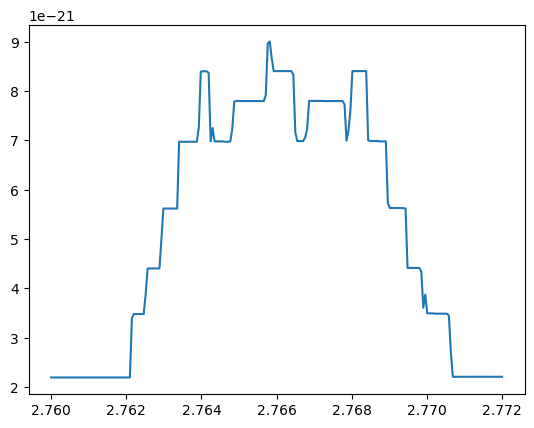

In [14]:
plt.plot(df['Frequency']/1e9, df['Signal']/1e9)

In [17]:
df.to_csv(f'Hyperfine_{np.round(min_frequency/1e9, 5)}_{np.round(max_frequency/1e9, 6)}.csv')

In [18]:
import pandas as pd

In [19]:
df1 = pd.read_csv('Hyperfine_2.763_2.77.csv')
df2 = pd.read_csv('Hyperfine_2.76_2.772.csv')

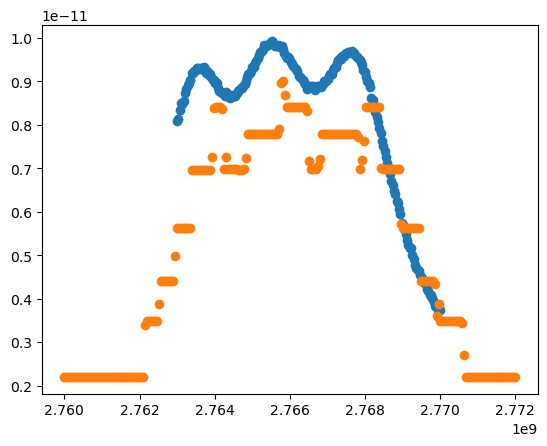

In [23]:
plt.plot(df1['Frequency'], df1['Signal'], 'o')
plt.plot(df2['Frequency'], df2['Signal'], 'o')

In [22]:
%pwd

'c:\\Users\\nv-group01\\Documents\\NV_Lab_Codes\\Lab 2 Templates'

In [11]:
# ODMR_data = result[0]
# ODMR = ODMR_data.to_pandas_dataframe()
# ODMR = ODMR_data.to_pandas_dataframe()
# indices = find_local_maxima(ODMR['Signal'], window_size=3)# tolerance=0.01e-11) 
# signal = ODMR['Signal']
# peaks = [freqs[i] for i in indices if signal[i] > 0.13e-11]

In [12]:
# ODMR.to_csv("hyperfine_data/-9db.csv")

In [13]:
# import pandas as pd
# df = []
# for power in [-3, -9, 6, 9]:
#     df.append(pd.read_csv(f"./hyperfine_data/{power}db.csv"))

powers = [-3, -9, 6, 9]


import numpy as np
import matplotlib.pyplot as plt
import math

for ODMR, power in zip(df, powers):
    plt.plot(ODMR["Frequency"], ODMR["Signal"])
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Signal(V)')
    plt.title(f'Hyperfine Splitting ({power}dBm)')
    #plt.xlim(2.7630e9, 2.7680e9)
    if power == -9:
        plt.xlim(2.7628e9, 2.7690e9)
    plt.savefig(f"./hyperfine_pics/hyperfine_{power}.png")
    plt.show()